# **Introduction**

Over the past decade, the NFL has significantly increased its utilization of data analytics to evaluate skill positions. Presently, utilizing innovations in tracking data and data science, teams can quantify a seemingly an infinite array of metrics to holistically assess skilled position players. However, while offensive and defensive players have taken the data analytics spotlight, punters have largely remained in the shadows. Luckily, <a href="https://operations.nfl.com/" target="_blank">NFL Football Operations</a>, with the work that Mike Lopez and his team have put into making the Big Data Bowl a reality, has provided the opportunity to shed light on punters. Utilizing the data provided, I developed a method to evaluate NFL punters. Over the course of this analysis, I will explain my method, model, metrics, and results in hopes that it will provide coaches and front offices a decision-making tool to enhance their special teams proficiency.

#### **Why Punting and How Punters are Currently Evaluated**
Speaking with multiple punters for this study, I was consistently told that a punt is the longest play in football. One might argue that the patented Tyreek Hill dump pass that ends in a 71-yard gain with 102 yards of accumulated travel distance certainly exceeds the time of a punt.  Certainly when it comes to time and yards covered these two plays can be compared. However, bear with me as I explain what is being conveyed by the punters’ claim. A punter is expected to take the field after an extended period and execute a proficient kick, regardless of where he’s located on the field, that will put his team’s defense in the best position to defend their own end zone. Unlike most offensive and defensive players, a punter’s miscue (i.e. a fumbled snap or shanked punt) is final. There is not another immediate down for them to retry their craft. Punter’s no-fail, one-time mission deserves greater examination and a more careful evaluation.

Currently, the NFL and many other sources rely heavily upon a punter’s average kick length, net average kick length after return, times they pin an opponent inside the 20-yard line, net yards for all punts and a few other statistics that rarely take into consideration actual game play. But punting has many intricacies that aren’t taken into account by these traditional metrics and that is why a new evaluative model is necessary.

#### **My Evaluation of Punters**
My analysis will propose a new evaluation technique that will shed light on the intricacies of punting. This evaluation will combine the following metrics and are broken down by Game Play Effect and Accuracy Effect:

1. **Game Play Effect Metrics**
    * Punt Yards Over Expected **(PYOE)**: relies on a gradient boosting model to predict the expected punt yards for a punter prior to kick.
    * Punt Positional Rating **(PPR)**: considers where a punter is located on the field and their ability to maximize time for their punt team to establish coverage.
    * Return Rating **(RR)**: accounts for how many times the result of the punt is a return.
    * Expected Points Subtracted Rating **(EPSR)**: uses the location of the kick to account for the opposing team’s EP if the team takes possession from where the ball is downed, fair caught, or received.


2. **Accuracy Metrics**
    * Pinned Within 5-Yards, 10-Yards, 20-Yards **(P5, P10, P20)** Ratings: annotates the number of times that a player pins their opponent within each yard line range.
    * Numbers Rating **(NR)**: accounts for punts that were inside of the numbers or outside of the numbers at the point of reception or landing.
    * Coverage Rating **(CR)**: considers how often a punter punts towards or away from their pre-snap coverage.

Throughout the rest of this analysis, inside and outside of the numbers will be referred to. Please see ***Figure 1*** for the explanation.

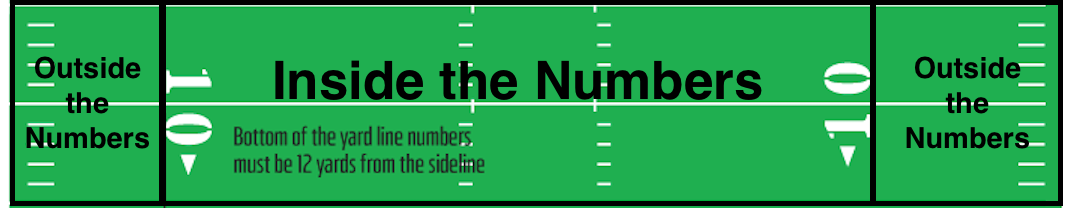
<center> Figure 1
<hr>

# **The Data**
My evaluation technique relies heavily upon the tracking data, <a href="https://www.pff.com/" target="_blank">Pro Football Focus</a> data, and a few data points extrapolated from public sources. The data ranged from grid coordinates for players on all special teams play for the 2018 through 2020 seasons to the weather conditions extant during the game. For this analysis, I focused on using the following features to help evaluate punters and build the expected punt yards model.

* <code>specialTeamsType</code>: type of special teams plays.
* <code>x, y</code>: location of the ball at snap until the ball was received, fair caught, out of bounds, downed or the play resulted in a touchback.
* <code>snapDetail</code>: details on whether the snap was on target, to the left, to the right, high or low.
* <code>operationTime</code>: elapsed time from the punter receiving the punt until it was kicked.
* <code>hangTime</code>: elapsed time from the kick of the ball until the ball is caught or lands on the field.
* <code>kickDirectionalIntended</code>: direction that the punter is expected to punt the ball based on how the punting team sets up coverage.
* <code>kickDirectionActual</code>: direction that the ball is punted broken down by center, left or right.
* <code>kickLength</code>: total yards the ball traveled in the air.
* <code>precipitation</code>: amount of precipitation over the length of the game.
* <code>windSpeed and windDirection</code>: the wind’s speed and direction compared against the direction that the stadium is orientated.
* <code>temperature, pressure, and elevation</code>: basic stadium factors.

<hr>

# **Exploratory Data Analysis**
My EDA primarily focused on understanding where on the field punters are aiming their kicks. The analysis considers the location of the ball and the result of the play. For readability, if the ball landed, bounced, and was then downed then the location that it was downed is annotated and not the bounce. Additionally, all muffed punts were not included in this analysis. Because I wanted to evaluate each punter independently during this initial stage, I conducted EDA to see if there were any insights that could be pulled from a basic plot of punts based on their x,y-coordinates. All plays were manipulated to play from left to right for standardization. For example, ***Figure 2*** shows a plot for the Kansas City Chiefs’ punter, Tommy Townsend, during the 2020 season.

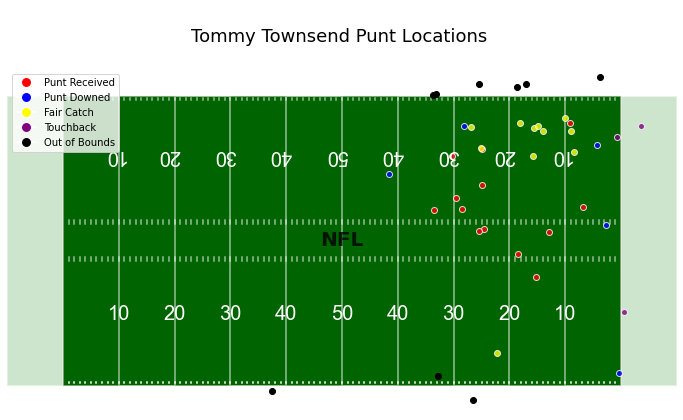

<center> Figure 2 

From this plot, it can be said that when Townsend punts to the middle of the field his punts are being returned more frequently than when he punts towards the sidelines. In 2020, 69% of punts that were returned were those kicked inside of the numbers. 

Seeing that a significant weight is currently placed on kick length to evaluate punters, the next step in my analysis was to plot punt length and examine how it compared to a punters’ ability to maintain accuracy. ***Figure 3*** is an example of a punt chart for Townsend during the 2020 season.

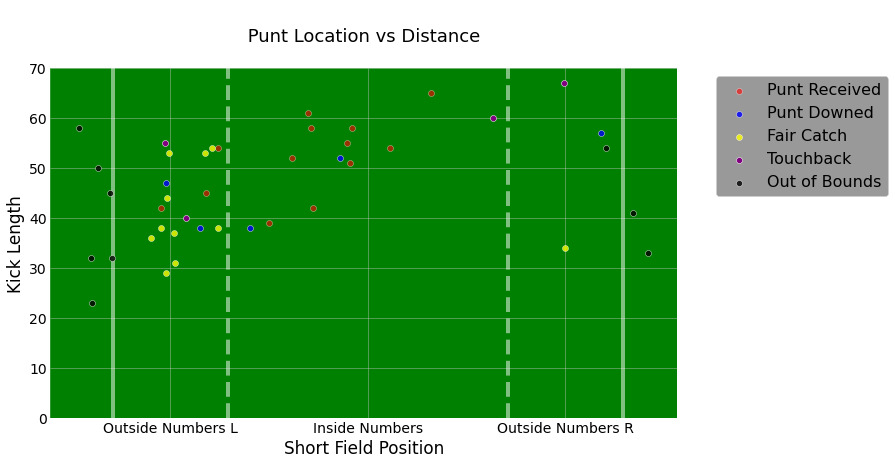
<center> Figure 3

This chart illustrates a few things when it comes to punting that are not taken into consideration when looking at a punter’s traditional stats. It shows that as Townsend increases the length of a punt, the closer to the center of the field the punts become. It appears he sacrifices the accuracy of his punts for total distance, which is not always detrimental depending on field position. Additionally, after 50-yards he is out kicking his punt coverage based on the number of times his punts are being returned. Lastly, we can clearly see from this chart that Townsend tends to favor his left side more frequently than his right side.
    
<hr>

# **Metrics**
Each metric is geared to isolate the punter’s individual performance and minimize bias based on the performance of their punt team coverage. If a great punter has a below average punt return team, their stats can be heavily influenced based on the current system of evaluation. As stated above, the proposed metric is comprised of two parts- game play effect and accuracy effect, both unweighted. For future analysis, weights can be assigned based on a coordinator's play strategy. 

## **Game Play Effect (GPE)**



### **Punt Yards Over Expected (PYOE)**
I used a gradient boosted regression model to calculate the expected punt yards portion of this metric. I ran and compared both <a href="https://lightgbm.readthedocs.io/en/latest/" target="_blank">LightGBM</a> and <a href="https://xgboost.readthedocs.io/en/stable/" target="_blank">XGBoost</a> were both ran and compared to optimize the model. My model took into account the location of the ball, placement of snap, wind effects, and pressure altitude. The rationale behind using pressure altitude was to see the impact of elevation on a punters kick length (think Mile High in Denver). Using SHAP, feature importance was determined as seen in *Figure 4*.

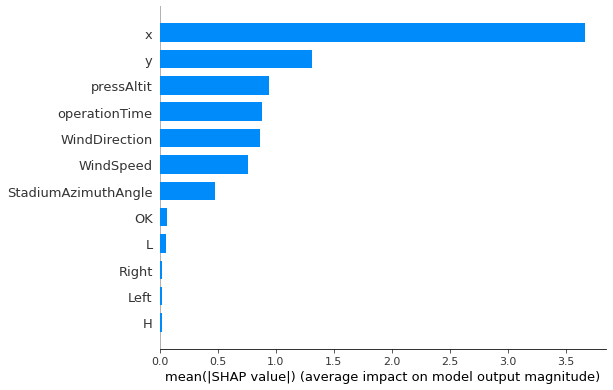
Figure 4 

As intuition would suggest, the x-coordinate of a play is the most important feature in predicting punt length for a play. The closer a punter is to their own endzone, the further they try to punt the ball to achieve better field position for their defense. With hyper parameter tuning using gridsearchcv,  XGBoost came out with the best MAE cross validation score of 5.3. Using these predictions against punter’s actual punts, I assigned a score to see how they were performing against the expected yards.

### **Punt Positional Rating (PPR)**
Currently, hang time is a heavily weighted statistic because it indirectly measures a punt coverage team’s ability to get down field and cover the punt. However, it does not consider the length of the kick which significantly influences the mean hangtime for a punter. PPR considers this feature. 

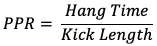

### **Return Rating (RR)**
Like the current stat, this is the percentage of punts that are not returned.

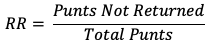

### **Expected Points Subtracted Rating (EPSR)**
These calculations were inspired by Wayne Winston’s book Mathletics. In the book, Winston references <a href="https://www.footballoutsiders.com/" target="_blank">Footballoutsiders.com’s</a> expected points for 1st & 10 situations for offensive positions based on their field position. Using this expectation model, each punt was given an expected point value for the opposing team's starting field position, if they started where the punt was received, fair caught, or landed.

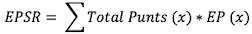

## **Accuracy Effect (AE)**



### **Pinned Within 5-Yards, 10-Yards, 20-Yards (P5, P10, P20) Ratings**
These ratings help recognize punters that are pinning teams deep in their own territory.

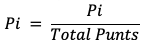

### **Numbers Rating (NR)**
Calculated by the percentage of punts that are kicked outside of the numbers which gives the punt return team the least chance of returning the ball.

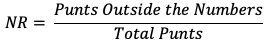

### **Coverage Rating (CR)**
Calculated by the percentage of punts that go away from the punt coverage direction.

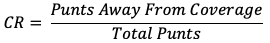

<hr>


## **Total Punter Rating (TPR)**
After combining GPE and AE, punters can be ranked by their performance on the field. ***Figure 5*** plots all punters in the 2020 season who completed at least 40 punts.

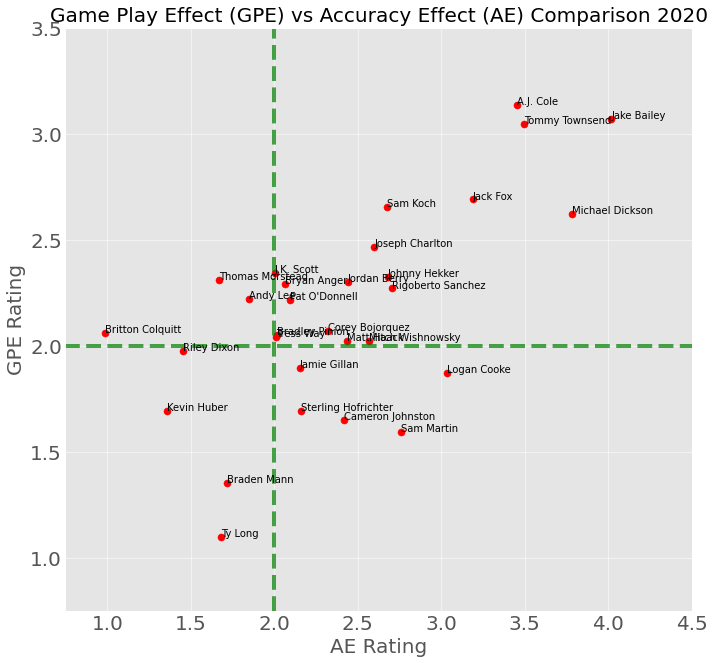

<center> Figure 5 
    
Using AE and GPE, ***Figure 5*** illustrates that A.J. Cole of the Las Vegas Raiders scored the highest for game play effect and Jake Bailey of the New England Patriots scored the highest for accuracy effect rating. Bailey was selected to his first Pro Bowl and earned All-Pro recoginition in 2020. As a predictor for this year, A.J. Cole was selected to his first Pro Bowl in 2021.
    
TPR is meant to be viewed as a total rating between the metrics of GPE and AE. Some of the sub metrics have weakness that other sub metrics account for.  Such as in ***Figure 6***, Tommy Townsend's ESPR rating is relatively lower than the the top four punters and that is largely due to the fact tha he is punting from deeper in his own territory than other punters. However, this weakness is compensated for when looking at his PPR. 

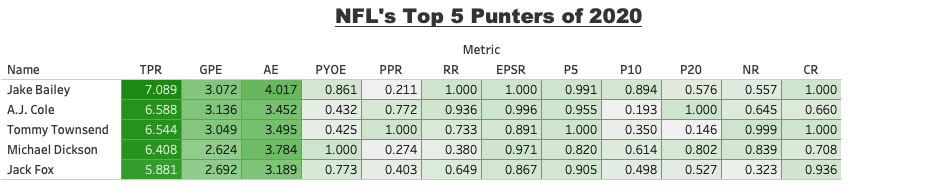

<center> Figure 6

<hr>

# **Closing**
Bringing it back out of the endzone, this analysis has evaluated punters in the NFL against one another and found that accuracy of a punter is important in determining whether a punt is returned. TPR is a holistic approach to evaluating punters and their performance based on their own individual skills and not the unit. This analysis can be important to a team when it comes to player retention or when game planning for an opponent. In the case of the Chiefs’ Townsend, a special teams coordinator could game plan off the fact he tends to favor his left in shorter field situations and that his punt coverage begins to breakdown above 55 yards. ***Figure 7*** is an example of what could be provided to help with game planning or front office decisions.

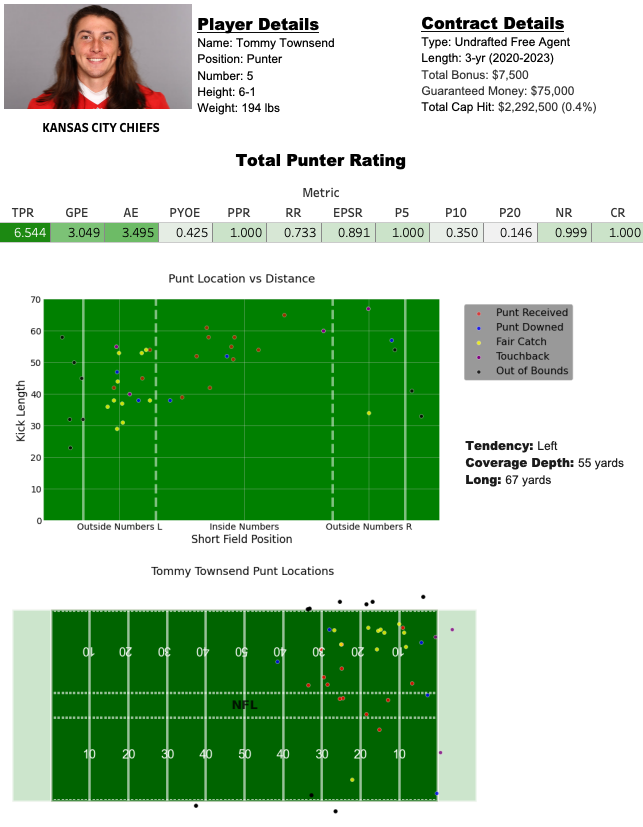

<center> Figure 7 

<hr>

* I am extremely thankful for the opportunity to participate in this year's Big Data Bowl. I would like to thank Mike Lopez, Thomas Bliss, and Dhriti Yandapally for all the work that they have put into making this competition and putting together the <a href="https://operations.nfl.com/gameday/analytics/big-data-bowl/big-data-bowl-mentorship-program/" target="_blank">BDB Mentorship Program</a>. 
* My acknowledgements, references, and code used in this notebook can be found on my <a href="https://github.com/Charlestobi/NFL-Big-Data-Bowl" target="_blank">github repository</a>.